In [1]:
import import_ipynb
from DQN.modulatedDQN import Agent
import gym
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import losses
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import logging
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

importing Jupyter notebook from /home/deonix/maturarbeit-code/DQN-Implementations/DQN/DoubleDQNv2.ipynb


2022-08-20 01:55:40.580533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2022-08-20 01:55:40.710502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 01:55:40.710774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 01:55:40.715322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-20 01:55:40.716872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
#agent and environment optimized for Atari games
#https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

class AtariGame:
    def __init__(self, env_name, render_mode=None, name=None):
        self.name = name
        self.sample_batch_size = 32
        self.episodes          = 5e6
        self.env_name          = env_name
        self.render_mode       = render_mode
        self.env               = wrap_deepmind(env = make_atari(self.env_name, render_mode=render_mode),
                                               frame_stack=True, scale=True)
        self.frame_skip        = 4 #skip every 4th frame
        #84x84 greyscale
        self.reduzed_size      = (84, 84, self.frame_skip) #, greyscale(1), 84x84, 4 Pictures, 
        self.state_size        = self.reduzed_size
        self.action_size       = self.env.action_space.n
        self.termination_index = 10000
        self.history           = []
        self.save_freq         = 10000
        self.update_freq       = 10000 #update target every 10k frames
        self.random_min        = 50000
        self.agent             = Agent(self.state_size, self.action_size, 
                                       #Parameters taken from Deepmind Breakout AI
                                       #input model layers as keras.layers objects
                                       anatomy=[layers.Conv2D(16,8,strides=4,activation=activations.relu),
                                                layers.Conv2D(64,4,strides=2,activation=activations.relu),
                                                layers.Conv2D(64,3,strides=2,activation=activations.relu),
                                                layers.Flatten(),
                                                layers.Dense(512, activation=activations.linear)],
                                       name=f"{self.env_name}-DoubleDQN",
                                       linear_decrease=True,
                                       epsilon=1,
                                       epsilon_decay=0.9/31000/4,
                                       epsilon_min=0.1,
                                       model_verbose=0,
                                       lr=0.00025,
                                       gamma=0.99,
                                       optimizer=keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0),
                                       loss_function=losses.Huber(),
                                       max_memory_size=1e5
                                       )
        #print(self.state_size, self.action_size)
    
    def run(self, load_model = False, skip_training=False, overwrite_epsilon=-1, save=True, logs=False, log_freq=1):
        #LOGS ARE ALWAYS ENABLED
        logging.basicConfig(filename=f"models/{self.agent.default_name}.log",
                level=logging.INFO,
                format='%(levelname)s: %(asctime)s %(message)s',
                datefmt='%d/%m/%Y %I:%M:%S')
        
        #if true, try to load existing model
        if load_model:
            self.agent.load_model(overwrite_epsilon=overwrite_epsilon)
            
        try:
            training_batches = 0
            frames = 0
            for index_episode in range(int(self.episodes)):
                state = self.env.reset() #returns a LazyFrame
                state = np.array(state)
                state_tensor = tf.expand_dims(state, 0)
                done = False
                score = 0 
                q = 0
                q_n = 0
                
                for index in range(0, self.termination_index):
                    if index > self.frame_skip or frames > self.random_min:
                        action = self.agent.pick_action(state_tensor) 
                    else:
                        action = np.random.choice(self.agent.action_size)
                     
                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.array(next_state)
                    next_state_tensor = tf.expand_dims(next_state, 0)     
                    score += reward
                    #print(next_state.numpy().shape)
                    #store Lazyframes
                    self.agent.update_memory(state=state, 
                                             reward=reward, 
                                             action=action, 
                                             state_next=next_state, 
                                             done=done)
                    
                    if (index % self.frame_skip == 0) and not skip_training:
                        if index > self.frame_skip:
                            q += np.amax(self.agent.predict(state_tensor))
                            q_n += 1

                            training_batches += 1
                            self.agent.replay(debug=False)  
                            
                    if (frames % self.update_freq) == 0:
                        self.agent.update_target()
                        logging.info(f"MODEL UPDATE")
                        
                    state = next_state
                    state_tensor = next_state_tensor
                    
                    frames += 1
                    
                    if done:
                        break
                self.history.append(score)
                if len(self.history) > 100:
                    del self.history[:1]
                
                print(f"Episode: {index_episode:-10}")
                print(f"Score: {score:-12}")
                print(f"Epsilon: {self.agent.exploration_rate}")
                print("".join(["_" for i in range(10)]))
                if logs and index_episode % log_freq == 0:
                    running_reward = sum(self.history) / len(self.history)
                    logging.info(f"EPISODE: {index_episode}")
                    logging.info(f"AVG LAST {len(self.history)} REWARDS: {running_reward:0.2f}")
                    
                    if q_n != 0:
                        logging.info(f"AVG Q VALUE: {(q / q_n):.5f}")
                    logging.info(f"SCORE: {score}")
                    logging.info(f"DURATION (STEPS): {index}")
                    logging.info(str(self.agent))
                    logging.info("".join(["-" for i in range(12)]))
                
                if index_episode % self.save_freq == 0 and save and index_episode != 0:
                    self.agent.save_model(name="EP"+str(index_episode/1000)+"k", save_memory=False)
                
        except:
            if save:
                self.agent.save_model(name="ERROR", save_memory=False)
            logging.info("".join(["+" for i in range(14)]))
            logging.exception("An error has occured")
            logging.info("".join(["+" for i in range(14)]))
            
        finally:
            #save model upon interrupting
            if logs or save:
                logging.info(f"TRAINING FINISHED AFTER {training_batches} BATCHES")
                logging.info("".join(["+" for i in range(14)]))
                if save:
                    model_name = self.agent.build_name(name="FINISHED")
                    logging.info(f"MODEL NAME: {model_name}")
                logging.info("".join(["+" for i in range(14)]))
            #print(training_batches)
            if save:
                self.agent.save_model(name="FINISHED", save_memory=True)

if __name__ == "__main__":
    #render modes: "human", None
    atari = AtariGame("BreakoutNoFrameskip-v4", render_mode=None)
#     atari.run(load_model=False, skip_training=False, overwrite_epsilon=1, save=False, logs=True, log_freq=100)


In [37]:
env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
env1 = make_atari("BreakoutNoFrameskip-v4")
env.seed(1)
env1.seed(1)
agent = Agent(env.observation_space.shape, env.action_space.n)

Optimizer Adam: lr=0.001

                    NAME: DeepQNetwork
                    INPUT SHAPE: (84, 84, 4), OUTPUT SHAPE: 4
                    OPTIMIZER: <class 'keras.optimizers.optimizer_v2.adam.Adam'>
                    LOSS FUNCTION: <class 'keras.losses.MeanSquaredError'>
                    LEARNING RATE: 0.001
                    TARGET_NETWORK: enabled-> True
                                    target_updates->0
                    MEMORY: 0/1000000 ¦ 0.00%
                    EPSILON: 1.000000
                             min-> 0.0001
                    ACTIONS TAKEN:  greedy-> 0
                                    exploration-> 0
                    REPLAY: batch_size-> 32
                            gamma-> 0.95
                            gradient_updates-> 0
                    


float32


False

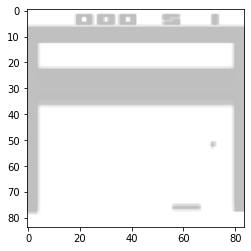

In [44]:
state = env.reset()
state = np.array(state)
print(state.dtype)
plt.imshow(state)
plt.savefig(fname="Breakout_pre",dpi=600)

compressed = agent.replay_compress(state)
uncompressed = agent.replay_unpack(compressed)

np.equal(state, uncompressed).all()

In [43]:
state1 = env1.reset()

state1 = env1.step()
plt.imshow(state1)
# plt.savefig(fname="Breakout_raw",dpi=1000)


TypeError: step() missing 1 required positional argument: 'action'